# 时序差分算法
## 简介
本章将要学习强化学习中两大经典算法：Sarsa和Q-learning，它们都是基于时序差分的强化学习算法。不同于之前学习的基于动态规划的算法，基于时序差分的算法不需要事先知道环境的状态转移函数和奖励函数，而直接使用和环境交互采样到的数据即可，这使得其可以被应用到一些简单的实际场景中。同时，这节课程还会引入一组概念：在线策略学习和离线策略学习。通常来说，离线策略学习能够更好的利用历史数据，并因此具有更小的样本复杂度（算法达到收敛结果需要在环境中采样的样本数量），这使得离线策略学习的算法通常更受欢迎。

## 时序差分（Temporal Difference）方法

时序差分方法是一种用来估计一个策略的价值函数的方法。它结合了动态规划和蒙特卡洛方法的思想。它和蒙特卡洛的相似之处在于可以从样本数据中学习，不需要事先知道环境。它与动态规划的相似之处在于根据贝尔曼方程的思想利用状态价值的估计来进行更新。回顾一下蒙特卡洛方法对价值函数的增量更新方式：
$$
V(S_t) \leftarrow V(S_t) + \alpha [G_t - V(S_t)]
$$
这里我们将之前的$\frac{1}{k}$替换成了$\alpha$，表示对价值估计更新的步长。我们可以将$\alpha$取为一个常数，此时更新方式不再是像蒙特卡洛方法严格的取平均。蒙特卡洛方法必须要等整个序列结束之后才能计算得到这一次的回报$G_t$。而时序差分方法只需要当前步结束就行，具体来说它用当前获得的奖励加上下一个状态的价值估计来当作在当前状态会获得的回报，即
$$
V(S_t) \leftarrow V(S_t) + \alpha [R_t + \gamma V(S_{t+1}) - V(S_t)]
$$
其中$R_t + \gamma V(S_{t+1}) - V(S_t)$通常被称为时序差分误差（TD Error），时序差分算法将其乘以步长之后作为状态价值的更新量。我们可以用$R_t + \gamma V(S_{t+1})$来代替$G_t$的原因是
$$
\begin{align}
 V_\pi(s) &= \mathbb{E}_\pi[G_t|S_t=s] \nonumber \\
 &= \mathbb{E}_\pi[\sum_{k=0}^\infty \gamma^k R_{t+k}|S_t=s]  \nonumber \\
				&= \mathbb{E}_\pi[ R_t + \gamma \sum_{k=0}^\infty \gamma^k R_{t+k+1} |S_t=s] \nonumber \\
				&= \mathbb{E}_\pi[R_t + \gamma V_\pi(S_{t+1})|S_t=s] \nonumber 
\end{align}
$$
所以蒙特卡洛方法用第一行来当作更新的目标，而时序差分方法用最后一行来当作更新的目标。于是，在用策略和环境交互时，每采样一步，我们就可以用时序差分方法来更新价值估计。虽然它用到了$V(S_{t+1})$的估计值，可以证明它最终收敛到策略$\pi$的价值函数，我们在此不对此进行展开说明。








## Sarsa

既然我们可以用时序差分方法来估计价值函数，那一个很自然的问题是，我们能否用类似策略迭代的方法来进行强化学习。由于策略评估我们已经可以通过时序差分实现，那么在不知道奖励函数和状态转移函数的时候该怎么进行策略提升呢？答案是我们直接用时序差分方法来估计动作价值函数$Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)]
$$
然后我们用贪心方法来选取使得在某个状态下动作价值最大的那个动作，即$\arg\max_a Q(s, a)$。这样貌似已经形成了一个完整的强化学习算法：我们用贪心法根据动作状态价值选取动作和环境交互，得到的数据再用时序差分方法来更新动作价值函数的估计。

然而这个简单的算法存在两个方面需要进一步的考虑。第一个方面是，如果我们要准确地用时序差分方法来估计策略的价值函数，我们需要用**非常多数量**的样本来进行更新。但实际上我们可以忽略这一点，直接用**一些**样本来评估策略，然后就可以更新策略了。我们可以这么做的原因是我们不必完全进行策略评估就去进行策略提升，回顾一下价值迭代就是这样。这其实是通用策略迭代（Generalized Policy Iteration）的思想。第二个方面是，如果我们在策略提升中，一直根据贪心法得到一个确定性策略，可能会导致某些状态动作对$(s,a)$永远没有在序列中出现，于是我们无法对其动作价值进行估计，进而无法保证策略提升后的策略比之前的好。这其实就是强化学习中非常重要的探索问题。简单常用的解决方案是不再一昧使用贪心法，而是采用一个$\epsilon$-greedy策略：有$1 - \epsilon$的概率采用动作价值最大的那个动作，另外会有$\epsilon$的概率从动作空间中随机采取一个动作。公式表示为
$$
\pi(a|s)=\left\{
\begin{align}
&\epsilon/|\mathcal{A}| + 1 - \epsilon \quad \quad  if \; a = \arg\max_{a'} Q(s,a') \nonumber\\
&\epsilon/|\mathcal{A}| \quad \quad\quad \quad\quad \; otherwise \nonumber\\
\end{align}
\right.
$$
现在，我们就可以得到一个实际的基于时序差分方法的强化学习算法。这个算法被称为Sarsa，因为它的动作价值更新用到了当前状态$s$，当前动作$a$，获得的奖励$r$，下一个状态$s'$和下一个动作$a'$，将这些符号拼接后就得到了算法名称。Sarsa的具体算法如下：
- 初始化$Q(s,a)$
- 不断进行$N$次如下循环(每个循环是一条序列)：
	- 得到初始状态$s$
	-	用$\epsilon$-greedy策略根据$Q$选择当前状态$s$下的动作$a$
	- 不断进行如下循环直至终止状态（每个循环是序列中的一步）:
		- 得到环境反馈的$r, s'$
		- 用$\epsilon$-greedy策略根据$Q$选择当前状态$s'$下的动作$a'$
		- $Q(s,a) \leftarrow Q(s,a) + \alpha[r + \gamma Q(s',a')-Q(s,a)]$
		- $s\leftarrow s', a\leftarrow a'$

我们仍然在Cliff Walking环境下来尝试一下Sarsa算法。首先我们先来看一下Cliff Walking环境的代码，这份环境代码和动态规划中的不一样，因为此时环境不需要提供奖励函数和状态转移函数，而是需要提供和智能体进行交互的函数step，该函数将智能体的动作作为输入，输出奖励和下一个状态给智能体。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # tqdm是显示循环进度条的库

class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow       
        self.ncol = ncol
        self.x = 0 # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1 # 记录当前智能体位置的纵坐标

    def step(self, action): # 外部调用这个函数来让当前位置改变
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]] # 4 种动作, 0:上, 1:下, 2:左, 3:右。原点(0,0)定义在左上角
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0: # 下一个位置在悬崖或者终点
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self): # 回归初始状态，起点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

然后我们来实现Sarsa算法，主要维护一个表格Q_table用来储存当前策略下所有状态动作对的价值，在用Sarsa算法和环境交互时，用$\epsilon$-greedy策略进行采样，在更新Sarsa算法时，使用时序差分的公式。我们默认终止状态时所有动作的价值都是0，这些价值在初始化为0后就不会进行更新。

In [2]:
class Sarsa:
    """ Sarsa算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action]) # 初始化Q(s,a)表格
        self.n_action = n_action # 动作个数
        self.alpha = alpha # 学习率
        self.gamma = gamma # 折扣因子
        self.epsilon = epsilon # epsilon-greedy策略中的参数
        
    def take_action(self, state): #选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state): # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action): # 若两个动作的价值一样，都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

接下来我们就在Cliff Walking环境中开始运行Sarsa算法，一起来看看结果吧！

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 2210.25it/s, episode=500, return=-18.900]


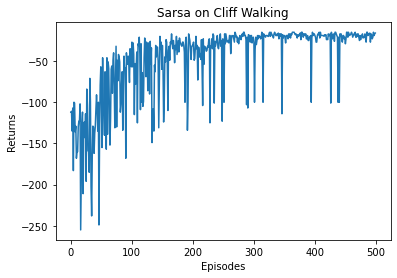

In [3]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500 # 智能体在环境中运行多少条序列

return_list = [] # 记录每一条序列的回报
for i in range(10): # 显示10个进度条
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar: # tqdm的进度条功能
        for i_episode in range(int(num_episodes/10)): # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done: 
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            return_list.append(episode_return) 
            if (i_episode+1) % 10 == 0: # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')   
plt.ylabel('Returns')  
plt.title('Sarsa on {}'.format('Cliff Walking'))  
plt.show()

我们发现Sarsa算法随着训练，获得的回报越来越高。在进行500条序列的学习后，可以获得负二十左右的回报，此时已经非常接近最优策略了。然后我们看一下Sarsa算法得到的策略在各个状态下会采取怎么样的动作。

In [4]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster: 
                print('****', end=' ')
            elif (i * env.ncol + j) in end: 
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()

action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


我们发现Sarsa算法会采取比较远离悬崖的策略来抵达终点。

## 多步Sarsa算法
时序差分方法只利用一步奖励和下一个状态的价值估计，而蒙特卡洛方法利用之后每一步的奖励而不使用任何价值估计。那他们之间的区别是什么呢？总的来说，蒙特卡洛方法是无偏（unbiased）的，但是具有比较大的方差，因为每一步动作得到不一样的奖励最终都会加起来，极大影响最终的价值估计；而时序差分方法具有非常小的方差，因为只用到了一步的奖励，但是它是有偏的，因为我们用到了下一个状态的价值估计而不是其真实的价值。那有没有什么方法可以结合两者的优势呢？答案是多步时序差分！多步时序差分的意思是我们使用$n$步的奖励，然后再用之后的状态价值估计。用公式表示，我们将 
$$
G_t = R_t + \gamma Q(S_{t+1},A_{t+1})
$$
替换成 
$$
G_t = R_t + \gamma R_{t+1} + \dots + \gamma^nQ(S_{t+n},A_{t+n}).
$$
于是，相应的存在一种多步Sarsa算法，它是把之前Sarsa算法中的值函数的更新公式
$$
Q(S_t,A_t)\leftarrow Q(S_t,A_t) + \alpha[R_{t} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t)]
$$
替换成
$$
Q(S_t,A_t)\leftarrow Q(S_t,A_t) + \alpha[R_t + \gamma R_{t+1} + \dots + \gamma^nQ(S_{t+n},A_{t+n}) - Q(S_t,A_t)].
$$


我们接下来实现一下多步Sarsa算法。我们在Sarsa代码的基础上进行修改，引入多步时序差分计算。

In [5]:
class nstep_Sarsa:
    """ n步Sarsa算法 """
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action]) 
        self.n_action = n_action 
        self.alpha = alpha 
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n # 采用n步Sarsa
        self.state_list = [] # 保存之前的状态
        self.action_list = [] # 保存之前的动作
        self.reward_list = [] # 保存之前的奖励

    def take_action(self, state): 
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def best_action(self, state): # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1, done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        if len(self.state_list) == self.n: # 若保存的数据可以进行n步更新
            G = self.Q_table[s1, a1] # 得到Q(s_{t+n}, a_{t+n})
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.reward_list[i] # 不断向前计算每一步的回报
                if done and i > 0: # 如果到达终止状态，最后几步虽然长度不够n步，我们也对其进行更新
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
            s = self.state_list.pop(0) # 需要更新的状态动作从列表中删除，下次不必更新
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a]) # n-step sarsa的主要更新步骤
        if done: # 如果到达终止状态，即将开始下一条序列，则将列表全清空
            self.state_list = []
            self.action_list = []
            self.reward_list = []

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 1074.44it/s, episode=500, return=-19.100]


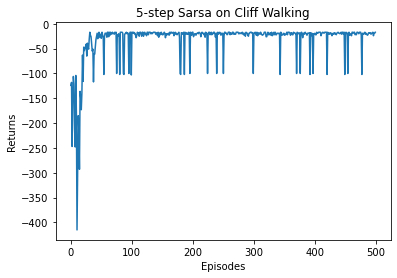

In [6]:
np.random.seed(0)
n_step = 5 # 5步Sarsa算法
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500 # 智能体在环境中运行多少条序列

return_list = [] # 记录每一条序列的回报
for i in range(10): # 显示10个进度条
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar: # tqdm的进度条功能
        for i_episode in range(int(num_episodes/10)): # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done: 
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action, done)
                state = next_state
                action = next_action
            return_list.append(episode_return) 
            if (i_episode+1) % 10 == 0: # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')   
plt.ylabel('Returns')  
plt.title('5-step Sarsa on {}'.format('Cliff Walking'))  
plt.show()

通过实验结果我们发现，5步Sarsa算法的收敛速度比单步Sarsa更快。我们来看一下此时的策略表现。

In [7]:
action_meaning = ['^', 'v', '<', '>']
print('5步Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

5步Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo 
ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


我们发现此时多步Sarsa算法得到的策略会在最远离悬崖的一边行走，保证最大的安全性。

## Q-Learning

除了Sarsa，还有一种非常著名的基于时序差分方法的强化学习算法Q-learning。Q-learning和Sarsa的最大区别在于Q-learning的时序差分更新方式为
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t)]
$$
它的具体算法为
- 初始化$Q(s,a)$
- 不断进行$N$次如下循环(每个循环是一条序列)：
	- 得到初始状态$s$
	- 不断进行如下循环直至终止状态（每个循环是序列中的一步）:
		- 用$\epsilon$-greedy策略根据$Q$选择当前状态$s$下的动作$a$
		- 得到环境反馈的$r, s'$
		- $Q(s,a) \leftarrow Q(s,a) + \alpha[r + \gamma \max_{a'} Q(s',a')-Q(s,a)]$
		- $s\leftarrow s'$

我们可以用价值迭代的思想来理解Q-learning，即Q-learning是直接在估计$Q_*$，因为动作价值函数的贝尔曼最优方程是
$$
Q_*(s,a) = r(s,a) + \gamma \sum_{s' \in \mathcal{S}}p(s'|s,a) \max_{a'} Q_*(s',a')
$$
而Sarsa是在估计当前$\epsilon$-greedy策略的动作价值函数。需要强调的是Q-learning的更新并非必须使用当前贪心策略$\arg\max Q$采样得到的数据，因为给定任意$(s,a,s')$都可以直接根据更新公式来更新$Q$，为了探索通常使用一个$\epsilon$-greedy策略来与环境交互；而Sarsa必须使用当前$\epsilon$-greedy策略采样得到的数据，因为它的更新中用到的$Q(s', a')$的$a'$是当前策略在$s'$下的动作。我们称Sarsa是在线策略（on-policy）算法，称Q-learning是离线策略（off-policy）算法，这两个概念强化学习中非常重要。

### 在线策略与离线策略
首先我们称采样数据的策略为行为策略（behavior policy），称用这些数据来更新的策略为目标策略（target policy）。在线策略（on-policy）方法指的是行为策略和目标策略是同一个策略；而离线策略（off-policy）方法指的是行为策略和目标策略不是同一个策略。Sarsa是典型的在线策略算法，而Q-learning是典型的离线策略算法。在之后课程介绍中，我们将会注明各个算法属于这两类的哪一类。通常来说，离线策略算法能够更好的利用历史数据，并因此具有更小的样本复杂度（算法达到收敛结果需要在环境中采样的样本数量），这使得离线策略学习的算法通常更受欢迎。

我们接下来仍然在Cliff Walking环境下来尝试一下Q-learning算法。

In [8]:
class QLearning:
    """ Q-learning算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action]) # 初始化Q(s,a)表格
        self.n_action = n_action # 动作个数
        self.alpha = alpha # 学习率
        self.gamma = gamma # 折扣因子
        self.epsilon = epsilon # epsilon-greedy策略中的参数
        
    def take_action(self, state): #选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def best_action(self, state): # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 2094.07it/s, episode=500, return=-61.700]


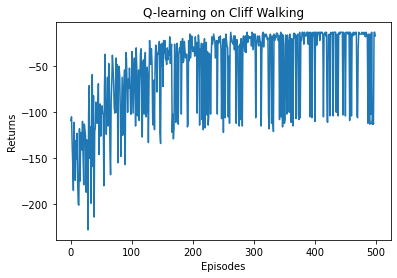

Q-learning算法最终收敛得到的策略为：
^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [9]:
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500 # 智能体在环境中运行多少条序列

return_list = [] # 记录每一条序列的回报
for i in range(10): # 显示10个进度条
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar: # tqdm的进度条功能
        for i_episode in range(int(num_episodes/10)): # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            done = False
            while not done: 
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state)
                state = next_state
            return_list.append(episode_return) 
            if (i_episode+1) % 10 == 0: # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')   
plt.ylabel('Returns')  
plt.title('Q-learning on {}'.format('Cliff Walking'))  
plt.show()

action_meaning = ['^', 'v', '<', '>']
print('Q-learning算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

需要注意的是，打印出来的回报是行为策略在环境中交互得到的，而不是Q-learning算法在学习的目标策略的真实回报。我们把目标策略的行为打印出来后，发现其更偏向于走在悬崖边上，这与Sarsa算法得到的比较保守的策略相比是更优的。

## 总结
Sarsa和Q-Learning算法是强化学习中两个非常基础的算法，当环境是有限状态集合和有限动作集合时，这两个算法非常好用。掌握这两个基础算法对接下来更深层次的学习很有帮助。不同的更新步长$\alpha$和超参数$\epsilon$对收敛速率会有影响，如果学习率过高就可能无法达到最优解，我们从理论中也能得到这样的结论。

## 扩展阅读：Q-Learning收敛性证明

学术界对于Q-learning算法的收敛性有着严格的数学证明。我们将进行简单阐述。我们首先来看一个引理。

**引理** 
如果一个随机过程$\Delta_t$的形式为$\Delta_{t+1}(x) = (1-\alpha_t(x))\Delta_t(x)+\alpha_t(x)F_t(x)$，那么它将收敛到0当满足以下条件时：
(1) $\sum_t\alpha_t(x)=\infty$
(2) $\sum_t\alpha_t^2(x)<\infty$
(3) $\|\mathbb{E}(F_t(x))\|_q\leq \gamma\|\Delta_t\|_q$，其中$\gamma < 1$
(4) $\text{var}(F_t(x))\leq C(1 + \|\Delta_t\|_q^2)$，其中$C$是一个大于0的常数

对于该引理的证明请参考文献：Tommi Jaakkola, Michael I. Jordan, and Satinder P. Singh. On the convergence of stochastic iterative dynamic programming algorithms. Neural Computation, 6(6):1185–1201, 1994.

在$t$时间步给定一个数据$(s,a,r,s')$，Q-learning原先的更新公式可以写成
$$
Q_{t+1}(s, a) = Q_t(s, a) + \alpha_t(s, a)[r + \gamma \max_{b\in \mathcal{A}}Q_t(s', b)-Q_t(s,a)]
$$
其中，我们令更新步长$\alpha$与时间$t$有关，并且有$0 \leq \alpha_t(s,a) \leq 1$。然后我们将其重写成以下形式：
$$
Q_{t+1}(s, a) = (1-\alpha_t(s, a))Q_t(s, a) + \alpha_t(s, a)[r + \gamma \max_{b\in \mathcal{A}}Q_t(s', b)]
$$
然后，我们假设$\sum_t \alpha_t(s,a) = \infty$以及$\sum_t \alpha_t^2(s,a) < \infty$，接下来我们就可以证明Q-learning的收敛性质了。我们先在上式等号左右两边减去$Q_*(s,a)$，然后令$\Delta_t(s, a)= Q_{t}(s, a)-Q_*(s,a)$，于是我们有:
$$
\Delta_{t+1}(s, a) = (1-\alpha_t(s, a))\Delta_t(s, a) + \alpha_t(s, a)[r + \gamma \max_{b\in \mathcal{A}}Q_t(s', b)-Q_*(s,a)]
$$
然后我们定义
$$
F_t(s, a) = r(s,a) + \gamma \max_{b\in\mathcal{A}}Q_t(s',b)-Q_*(s,a)
$$
于是我们有
$$
\mathbb{E}[F_t(s,a)] = r(s,a) +  \gamma \sum_{y\in \mathcal{S}} p(y|s,a) \max_{b\in\mathcal{A}}Q_t(y,b) -Q_*(s,a)
$$
像价值迭代收敛性证明过程中一样，我们在这定义算子
$$
\mathcal{H}Q_t(s,a)= r(s,a) +  \gamma \sum_{y\in \mathcal{S}} p(y|s,a) \max_{b\in\mathcal{A}}Q_t(y,b)
$$
于是我们有
$$
\mathbb{E}[F_t(s,a)] = \mathcal{H}Q_t(s,a) - Q_*(s,a)
$$
因为
$$
Q_*(s,a) = \mathcal{H}Q_*(s,a)
$$
所以
$$
\mathbb{E}[F_t(s,a)] = \mathcal{H}Q_t(s,a) - \mathcal{H}Q_*(s,a)
$$
我们可以证明$\mathcal{H}$是一个压缩算子，同学们可对照着上一节课内容自行证明。所以有
$$
\|\mathbb{E}[F_t(s,a)]\|_\infty = \|\mathcal{H}Q_t(s,a) - \mathcal{H}Q_*(s,a)\|_\infty \leq \gamma \| Q_t - Q_* \|_\infty = \gamma \|  \Delta_t \|_\infty
$$
接下来
$$
\begin{align}
\text{var}[F_t(s,a)] &=  \mathbb{E}[(F_t(s,a)- \mathbb{E}[F_t(s,a)])^2]                              \nonumber \\
&= \mathbb{E}[  ( r(s,a) + \gamma \max_{b\in\mathcal{A}}Q_t(s',b)-Q_*(s,a) -  \mathcal{H}Q_t(s,a) + Q_*(s,a)) ^2       ]             \nonumber \\
 &= \mathbb{E}[  ( r(s,a) + \gamma \max_{b\in\mathcal{A}}Q_t(s',b) -  \mathcal{H}Q_t(s,a)  )^2 ] \nonumber \\
 &= \text{var}[  r(s,a) + \gamma \max_{b\in\mathcal{A}}Q_t(s',b)  ]
\end{align}
$$
因为奖励函数$r$是有界的，所以存在一个$C$，使得
$$
\text{var}[F_t(s,a)]  \leq C(1 + \|\Delta_t\|_q^2)
$$
所以根据引理，$\Delta_t$能收敛到0，这意味着$Q_t$能够收敛到$Q_*$。